# Bayesian Dice

Think Bayes, Second Edition

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkBayes2/blob/master/examples/bayes_dice.ipynb)

I've been enjoying Aubrey Clayton's new book [*Bernoulli's Fallacy*](https://aubreyclayton.com/bernoulli). Chapter 1, which is about the historical development of competing definitions of probability, is worth the price of admission alone.

One of the examples in the first chapter is a simplified version of a problem posed by Thomas Bayes. The original version, [which I wrote about here](https://allendowney.blogspot.com/2015/06/bayesian-billiards.html), involves a billiards (pool) table; Clayton's version uses dice:

> Your friend rolls a six-sided die and secretly records the outcome; this number becomes the target *T*. You then put on a blindfold and roll the same six-sided die over and over. You're unable to see how it lands, so each time your friend [...] tells you *only* whether the number you just rolled was greater than, equal to, or less than *T*.
>
> Suppose in one round of the game we had this sequence of outcomes, with G representing a greater roll, L a lesser roll, and E an equal roll:
>
> G, G, L, E, L, L, L, E, G, L

Based on this data, what is the posterior distribution of *T*?

## Computing likelihoods

There are two parts of my solution; computing the likelihood of the data under each hypothesis and then using those likelihoods to compute the posterior distribution of *T*.

To compute the likelihoods, I'll demonstrate one of my favorite idioms, using a meshgrid to apply an operation, like `>`, to all pairs of values from two sequences.

In this case, the sequences are 

* `hypos`: The hypothetical values of *T*, and

* `outcomes`: possible outcomes each time we roll the dice

In [1]:
hypos = [1,2,3,4,5,6]
outcomes = [1,2,3,4,5,6]

If we compute a meshgrid of `outcomes` and `hypos`, the result is two arrays.

In [2]:
import numpy as np

O, H = np.meshgrid(outcomes, hypos)

The first contains the possible outcomes repeated down the columns.

In [3]:
O

array([[1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6],
       [1, 2, 3, 4, 5, 6]])

The second contains the hypotheses repeated across the rows.

In [4]:
H

array([[1, 1, 1, 1, 1, 1],
       [2, 2, 2, 2, 2, 2],
       [3, 3, 3, 3, 3, 3],
       [4, 4, 4, 4, 4, 4],
       [5, 5, 5, 5, 5, 5],
       [6, 6, 6, 6, 6, 6]])

If we apply an operator like `>`, the result is a Boolean array.

In [5]:
O > H

array([[False,  True,  True,  True,  True,  True],
       [False, False,  True,  True,  True,  True],
       [False, False, False,  True,  True,  True],
       [False, False, False, False,  True,  True],
       [False, False, False, False, False,  True],
       [False, False, False, False, False, False]])

Now we can use `mean` with `axis=1` to compute the fraction of `True` values in each row.

In [6]:
(O > H).mean(axis=1)

array([0.83333333, 0.66666667, 0.5       , 0.33333333, 0.16666667,
       0.        ])

The result is the probability that the outcome is greater than *T*, for each hypothetical value of *T*.
I'll name this array `gt`:

In [7]:
gt = (O > H).mean(axis=1)
gt

array([0.83333333, 0.66666667, 0.5       , 0.33333333, 0.16666667,
       0.        ])

The first element of the array is 5/6, which indicates that if *T* is 1, the probability of exceeding it is 5/6.
The second element is 2/3, which indicates that if *T* is 2, the probability of exceeding it is 2/3.
And do on.

Now we can compute the corresponding arrays for less than and equal.

In [8]:
lt = (O < H).mean(axis=1)
lt

array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333])

In [9]:
eq = (O == H).mean(axis=1)
eq

array([0.16666667, 0.16666667, 0.16666667, 0.16666667, 0.16666667,
       0.16666667])

In the next section, we'll use these arrays to do a Bayesian update.

## The Update

In this example, computing the likelihoods was the hard part. The Bayesian update is easy.
Since *T* was chosen by rolling a fair die, the prior distribution for *T* is uniform.
I'll use a Pandas `Series` to represent it.

In [10]:
import pandas as pd

pmf = pd.Series(1/6, hypos)
pmf

1    0.166667
2    0.166667
3    0.166667
4    0.166667
5    0.166667
6    0.166667
dtype: float64

Now here's the sequence of data, encoded using the likelihoods we computed in the previous section.

In [11]:
data = [gt, gt, lt, eq, lt, lt, lt, eq, gt, lt]

The following loop updates the prior distribution by multiplying by each of the likelihoods.

In [12]:
for datum in data:
    pmf *= datum

Finally, we normalize the posterior.

In [13]:
pmf /= pmf.sum()
pmf

1    0.000000
2    0.016427
3    0.221766
4    0.498973
5    0.262834
6    0.000000
dtype: float64

Here's what it looks like.

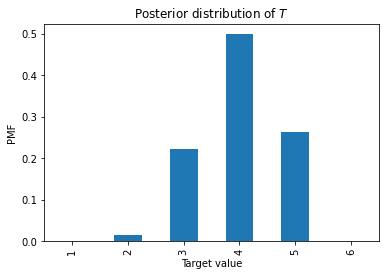

In [14]:
pmf.plot.bar(xlabel='Target value', 
             ylabel='PMF', 
             title='Posterior distribution of $T$');

As an aside, you might have noticed that the values in `eq` are all the same.
So when the value we roll is equal to $T$, we don't get any new information about *T*.
We could leave the instances of `eq` out of the data, and we would get the same answer.